In [1]:
# let's play with the spin isochrones from Spada & Lanzafame (2020)
# https://ui.adsabs.harvard.edu/abs/2020A%26A...636A..76S/abstract

In [719]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import skewnorm, exponnorm

In [50]:
df = pd.read_csv('SL20_tblA1.txt')
df.columns


Index(['Mass', 'B_V', 'T0.10', 'T0.12', 'T0.15', 'T0.20', 'T0.22', 'T0.25',
       'T0.30', 'T0.40', 'T0.50', 'T0.60', 'T0.70', 'T1.00', 'T1.50', 'T2.00',
       'T2.50', 'T4.00', 'T4.57'],
      dtype='object')

Text(0, 0.5, '$B - V$')

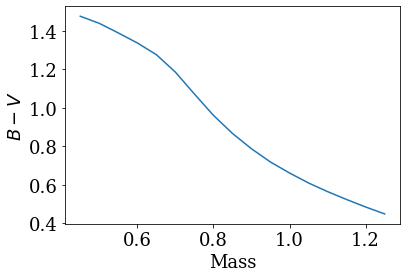

In [247]:
plt.plot(df['Mass'], df['B_V'])
plt.xlabel('Mass')
plt.ylabel('$B - V$')

Text(0, 0.5, 'P (days)')

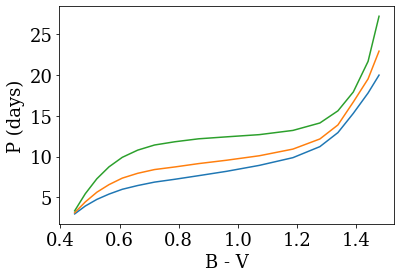

In [15]:
plt.plot(df['B_V'], df['T0.40'])
plt.plot(df['B_V'], df['T0.60'])
plt.plot(df['B_V'], df['T1.00'])
plt.xlabel('B - V')
plt.ylabel("P (days)")

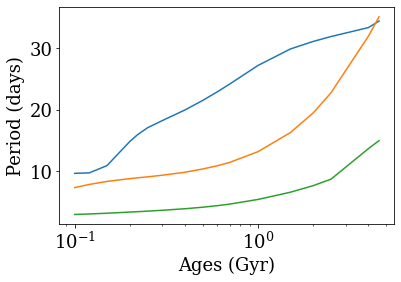

In [43]:
ages = [0.10,0.12,0.15,0.20,0.22,0.25,0.30,0.40,
        0.50,0.60,0.70,1.00,1.50,2.00,2.50,4.00,4.57]
ages = np.array(ages, dtype=np.float)

plt.plot(ages, df.iloc[0, 2:])
plt.plot(ages, df.iloc[5, 2:])
plt.plot(ages, df.iloc[15, 2:])
plt.xlabel('Ages (Gyr)')
plt.ylabel('Period (days)')
plt.xscale('log')

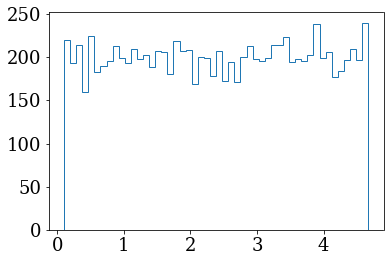

In [213]:
# If we assume ~constant star formation over the past 2 Gyr
# and a roughly uniform mass function (it's NOT, but it makes things easy...)
# -> can we make a quick forward model of what we expect to see in Kepler/K2?

nstars = 10000
age_big = np.random.random(size=nstars) * max(ages) + min(ages)
age_big = np.sort(age_big)
_ = plt.hist(age_big,histtype='step',bins=50)

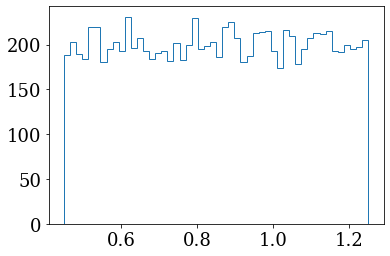

In [214]:
mass_big = np.random.random(size=nstars) * (df['Mass'].max() - df['Mass'].min()) + df['Mass'].min()
mass_big = np.sort(mass_big)
_ = plt.hist(mass_big,histtype='step',bins=50)

In [215]:
z = df.iloc[0:,2:].values
xx, yy = np.meshgrid(ages, df['Mass'].values)
f = interpolate.interp2d(xx.flatten(), yy.flatten(), z.flatten(), kind='linear')

In [216]:
xxnew, yynew = np.meshgrid(age_big, mass_big)

new_rot = f(age_big, mass_big)

In [217]:
print(new_rot.shape, age_big.shape, xxnew.shape)

(10000, 10000) (10000,) (10000, 10000)


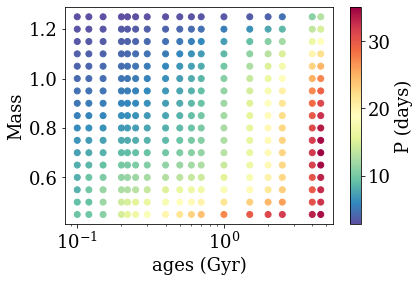

In [218]:
plt.scatter(xx.flatten(), yy.flatten(), c=z.flatten(), cmap=plt.cm.Spectral_r)
plt.xlabel('ages (Gyr)')
plt.ylabel('Mass')
plt.xscale('log')
cb = plt.colorbar()
cb.set_label('P (days)')


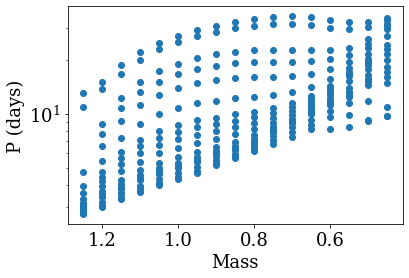

In [219]:
plt.scatter(yy, z)
plt.xlabel('Mass')
plt.ylabel('P (days)')
plt.yscale('log')
# plt.ylim(1,35)
# plt.xlim(0.52, 1.25)
plt.gca().invert_xaxis()

In [222]:
xxnew.flatten().size

100000000

In [223]:
Rind = np.random.choice(xxnew.flatten().size, nstars)

(0.52, 1.25)

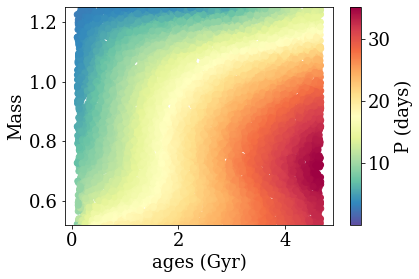

In [229]:
plt.scatter(xxnew.flatten()[Rind], yynew.flatten()[Rind], c=new_rot.flatten()[Rind], cmap=plt.cm.Spectral_r)
plt.xlabel('ages (Gyr)')
plt.ylabel('Mass')
# plt.xscale('log')
cb = plt.colorbar()
cb.set_label('P (days)')
plt.ylim(0.52, 1.25)

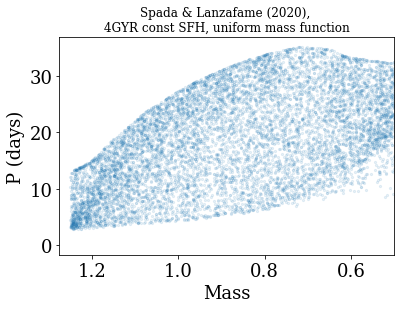

In [244]:
plt.scatter(yynew.flatten()[Rind], new_rot.flatten()[Rind], alpha=0.1, s=5)
plt.xlabel('Mass')
plt.ylabel('P (days)')
# plt.yscale('log')
# plt.ylim(3,40)
plt.xlim(0.5, 1.275)
plt.gca().invert_xaxis()
plt.title('Spada & Lanzafame (2020), \n4GYR const SFH, uniform mass function', fontsize=12)

plt.savefig('SL20_test.jpg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [544]:
def Angus2015(B_V, age):
    '''
    Compute the rotation period expected for a star of a given color (temp) and age

    NOTE: - input Age is in MYr
          - output Period is in days

    Eqn 15 from Angus+2015
    http://adsabs.harvard.edu/abs/2015MNRAS.450.1787A

    '''
    P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)

    return P


def Angus2015_age(B_V, P):
    '''
    invert the above eqn
    '''
    # P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)
    age = np.power(P / (0.4 * ((B_V - 0.45) ** 0.31)), 1. / 0.55)
    return age


def Wright2011_tau(BV):
    '''
    http://adsabs.harvard.edu/abs/2011ApJ...743...48W
    '''
    # values from their Table 2
    BV0 = [0.46,0.61,0.76,0.92,1.13,1.32,1.41,1.50,1.55,1.61]
    BV1 = [0.61,0.75,0.92,1.12,1.31,1.41,1.49,1.55,1.60,1.95]
    logtau = [1.01, 1.08, 1.18, 1.32, 1.41, 1.49, 1.71, 1.94, 1.97, 2.12]

    clr = (np.array(BV0) + np.array(BV1)) / 2.
    
    # fit parameters I created
    ff = [0.51138488, -0.24907552, 1.00734295]
    tau = 10**np.polyval(ff, BV)
    
    return tau


def Noyes1984_eqn4(B_V):
    '''
    Eqn 4 from the classic Noyes et al. (1984)
    http://adsabs.harvard.edu/abs/1984ApJ...279..763N
    
    empirical definition of Tau (convective turnover timescale) vs B-V color
    '''
    x = 1 - B_V
    
    # actuall the eqn for log tau_c
    tau = np.piecewise(x, [(x < 0),(x >= 0)], 
                       [lambda y: (1.362 - 0.14 * y), 
                        lambda y: (1.362 - 0.166 * y + 0.025 * y**2 - 5.323 * y**3)])
    
    return 10**tau


def _gaus(x, a, b, x0, sigma):
    """
    Simple Gaussian function
    Parameters
    ----------
    x : float or 1-d numpy array
        The data to evaluate the Gaussian over
    a : float
        the amplitude
    b : float
        the constant offset
    x0 : float
        the center of the Gaussian
    sigma : float
        the width of the Gaussian
    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b


def CranmerSaar2011_eqn36(Teff):
    """
    https://ui.adsabs.harvard.edu/abs/2011ApJ...741...54C
    """
    tau = 314.24 * np.exp(-1*(Teff / 1952.5) - ((Teff/6250)**18)) + 0.002
    return tau


def teff2bv(teff, logg=4.3, feh=0):
    """
    Relation from Sekiguchi & Fukugita (2000)
    https://arxiv.org/abs/astro-ph/9904299
    """    
    # from their Tbl 4:
    t = [-813.3175, 684.4585, -189.923, 17.40875]
    f = [1.2136, 0.0209]
    d1, g1, e1 = -0.294, -1.166, 0.3125
    BV = t[0] + t[1]*np.log10(teff) + t[2]*(np.log10(teff))**2 + \
            t[3]*(np.log10(teff))**3 + f[0]*feh + f[1]*feh**2 \
            + d1*feh*np.log10(teff) + g1*logg + e1*logg*np.log10(teff)
    return BV


def bv2teff(BV, logg=4.3, feh=0):
    """
    Relation from Sekiguchi & Fukugita (2000)
    https://arxiv.org/abs/astro-ph/9904299
    """
    # Full Sample, Tbl 3
    c = np.array([3.939654, -0.395361, 0.2082113, -0.0604097])
    f1, f2, g1, h1 = 0.027153, 0.005036, 0.007367, -0.01069
    
    logTeff = c[0] + c[1]*BV + c[2]*(BV**2) + c[3]*(BV**3) + \
               f1*feh + f2*(feh**2) + \
               g1*logg + h1*BV*logg
    return 10**logTeff
    

Text(0.5, 0, '$B-V$')

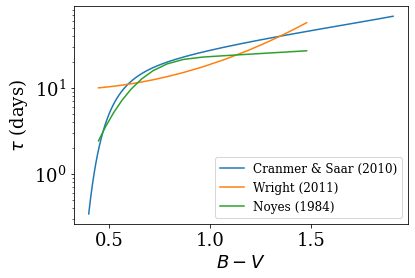

In [421]:
# comparing convective turnover timescale eqns...
plt.plot(teff2bv(np.arange(3000,6700,10)), CranmerSaar2011_eqn36(np.arange(3000,6700,10)), 
         label='Cranmer & Saar (2011)')

plt.plot(df['B_V'], Wright2011_tau(df['B_V']), label='Wright (2011)')
plt.plot(df['B_V'], Noyes1984_eqn4(df['B_V'].values), label='Noyes (1984)')

plt.legend(fontsize=12)
plt.ylabel(r'$\tau$ (days)')
plt.yscale('log')
plt.xlabel('$B-V$')

<ipython-input-442-a05fc4558aa0>:12: RuntimeWarning: invalid value encountered in power
  P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)


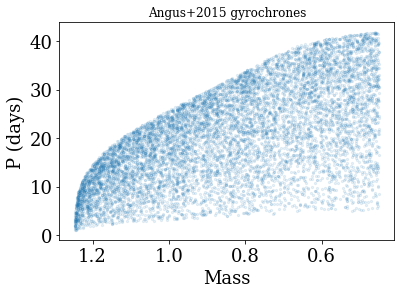

In [445]:
plt.scatter(yynew.flatten()[Rind], Angus2015(BVnew, xxnew.flatten()[Rind] * 1e3), alpha=.1,s=5)

plt.xlabel('Mass')
plt.ylabel('P (days)')
plt.title('Angus+2015 gyrochrones',fontsize=12)
plt.gca().invert_xaxis()


In [813]:
BVnew = np.interp(yynew.flatten()[Rind], df['Mass'].values, df['B_V'].values)

In [828]:
def stalldown(BV, age, Ro1=0.4, Ro2=0.6, skw=-20, samp=0.5,
              return_dP=False):
    '''
    BV: the B-V color of star(s)
        --> prob need to switch to Teff
    age: ages of star(s) in Myr (per Angus eqns)
    
    Ro1: Rossby number the gap starts at
    Ro2: Rossby number roughly the gap ends at
    `stalldown` uses Cranmer & Saar (2011) tau to estimate periods (P1, P2) 
        that these Ro's occur at
        
    `stalldown` inverts Angus+(2015) gyrochrone relation to estimate times (t1, t2)
        that these periods occur at

    skw: skewness of the stall vs acceleration
    
    samp: the stall amplitude, calculated as (P1 - P2)*samp
    
    return_dP: if True, return the period the stall dP(BV,age). 
        If Flase (default), return the Angus+(2015) gyro P(BV,age) 
        with dP included.
    '''
    
#     tau = Wright2011_tau(BV)
#     tau = Noyes1984_eqn4(BV)
    Teff = bv2teff(BV)
    tau = CranmerSaar2011_eqn36(Teff)
    
    P1 = Ro1 * tau
    P2 = Ro2 * tau
    t1 = Angus2015_age(BV,P1)
    t2 = Angus2015_age(BV,P2)

    # gaussian stall... not enough jump
#     dP = _gaus(age, (P1-P2)*0.75, 0, (t1+t2)/2, (t2 - t1)/2)

    dP = skewnorm(skw, loc=(t1+t2)/2, scale=(t2 - t1)/2).pdf(age) 
    # the normalization of the skewnorm dist might not be exactly right... but its close
    dP = dP  * (t2 - t1)/2 * np.sqrt(2*np.pi) / 2 * np.exp(1/(2*np.abs(skw))) * ((P1-P2)*samp)

    if return_dP:
        return dP
    else: 
        return Angus2015(BV, age) + dP


<ipython-input-544-8f5aceb0b58b>:21: RuntimeWarning: invalid value encountered in power
  age = np.power(P / (0.4 * ((B_V - 0.45) ** 0.31)), 1. / 0.55)
<ipython-input-544-8f5aceb0b58b>:12: RuntimeWarning: invalid value encountered in power
  P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)


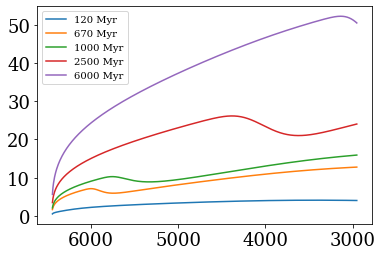

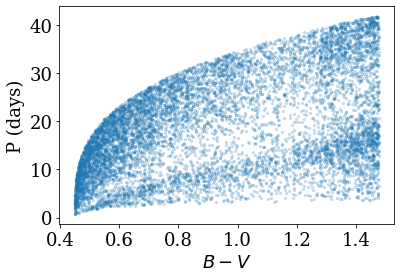

In [926]:
Ro1, Ro2, skw, samp = 0.5, .9, -3, 0.5

# lets make some fake clusters, see how it looks
bv_c = np.linspace(0.451, 1.9, 1000)
age_c = [120, 670, 1000, 2500, 6000]

for k in range(len(age_c)):
    plt.plot(bv2teff(bv_c), stalldown(bv_c, age_c[k], 
                                Ro1=Ro1, Ro2=Ro2, skw=skw, samp=samp), 
                label=str(age_c[k])+' Myr')
plt.legend(fontsize=10)
plt.gca().invert_xaxis()
plt.savefig('fake_clusters.jpg', dpi=150, bbox_inches='tight', pad_inches=0.25)

plt.figure()
plt.scatter(BVnew, stalldown(BVnew, xxnew.flatten()[Rind] * 1e3, 
                             Ro1=Ro1, Ro2=Ro2, skw=skw, samp=samp), 
            alpha=.2,s=5);
plt.xlabel('$B-V$')
plt.ylabel('P (days)')
plt.savefig('fake_field.jpg', dpi=150, bbox_inches='tight', pad_inches=0.25)

<ipython-input-544-8f5aceb0b58b>:12: RuntimeWarning: invalid value encountered in power
  P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)
<ipython-input-544-8f5aceb0b58b>:21: RuntimeWarning: invalid value encountered in power
  age = np.power(P / (0.4 * ((B_V - 0.45) ** 0.31)), 1. / 0.55)


Text(0.5, 1.0, 'test model')

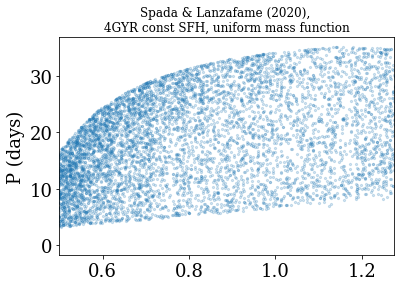

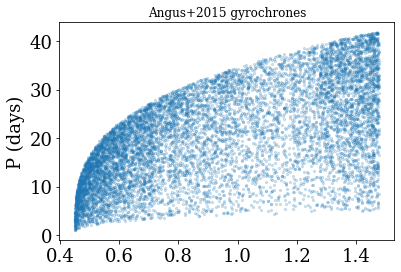

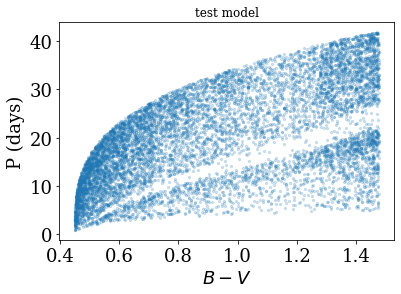

In [817]:
plt.scatter(BVnew, new_rot.flatten()[Rind], alpha=0.2, s=5)
plt.ylabel('P (days)')
plt.xlim(0.5, 1.275)
plt.title('Spada & Lanzafame (2020), \n4GYR const SFH, uniform mass function', fontsize=12)

plt.figure()
plt.scatter(BVnew, Angus2015(BVnew, xxnew.flatten()[Rind] * 1e3), alpha=.2,s=5)
plt.ylabel('P (days)')
plt.title('Angus+2015 gyrochrones',fontsize=12)

plt.figure()
plt.scatter(BVnew, stalldown(BVnew, xxnew.flatten()[Rind] * 1e3, Ro1=0.5, Ro2=0.7), 
            alpha=.2,s=5)
plt.xlabel('$B-V$')
plt.ylabel('P (days)')
plt.title('test model',fontsize=12)

<ipython-input-544-8f5aceb0b58b>:21: RuntimeWarning: invalid value encountered in power
  age = np.power(P / (0.4 * ((B_V - 0.45) ** 0.31)), 1. / 0.55)
<ipython-input-544-8f5aceb0b58b>:12: RuntimeWarning: invalid value encountered in power
  P = (age ** 0.55) * 0.4 * ((B_V - 0.45) ** 0.31)


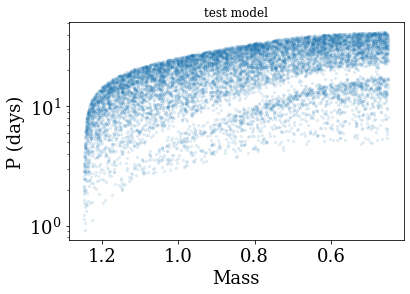

In [818]:
plt.scatter(yynew.flatten()[Rind], stalldown(BVnew, xxnew.flatten()[Rind] * 1e3), alpha=.1,s=5)

plt.xlabel('Mass')
plt.ylabel('P (days)')
plt.title('test model',fontsize=12)
plt.gca().invert_xaxis()
plt.yscale('log')